In [76]:
import pandas as pd 
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [77]:
# Creating a Neural Network Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [78]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [79]:
# from google.colab import files
# uploaded = files.upload()

In [80]:
# BASEDIR = '/content/gdrive/MyDrive/tools4f/'  # colab
BASEDIR = './'  # jupyter

In [81]:
SEED = 420

# Load preprocessed data

In [82]:
# df = pd.read_pickle(BASEDIR + 'df_merged_train_test.pickle')
df = pd.read_pickle(BASEDIR + 'df_merged_train_test_10.pickle')

X_train = df[0]
y_train = df[1]
X_test = df[2]
y_test = df[3]

X_train.frequency = X_train.frequency.astype('int8')
X_train.sum_ins = X_train.sum_ins.astype('int8')
X_train.pol_period = X_train.pol_period.astype('int8')
X_train.sex = X_train.sex.astype('int8')
X_train.entry_age = X_train.entry_age.astype('int8')
X_train.cnt_months = X_train.cnt_months.astype('int8')

X_test.frequency = X_test.frequency.astype('int8')
X_test.sum_ins = X_test.sum_ins.astype('int8')
X_test.pol_period = X_test.pol_period.astype('int8')
X_test.sex = X_test.sex.astype('int8')
X_test.entry_age = X_test.entry_age.astype('int8')
X_test.cnt_months = X_test.cnt_months.astype('int8')

In [83]:
print('# Train samples:', len(X_train))
print('# Test samples:', len(X_test))

# Train samples: 7888415
# Test samples: 1972104


## Optional: Pick smaller data for training

In [84]:
xy_train = pd.concat([X_train, y_train], axis=1)
xy_train_subset = xy_train.sample(frac=0.2, replace = False, random_state = np.random.RandomState())

In [85]:
y_train = xy_train_subset.pv_cf_rdr
X_train = xy_train_subset.drop(columns=['pv_cf_rdr'])

## Pick validation data

In [86]:
# first divison - train, validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, train_size=0.8, test_size=0.2, random_state=SEED)

In [87]:
print('# Train samples:', len(X_train))
print('# Val samples:  ', len(X_val))
print('# Test samples: ', len(X_test))

# Train samples: 1262146
# Val samples:   315537
# Test samples:  1972104


# One Hot Encoding

In [96]:
# Get one hot encoding
dummies_train = pd.get_dummies(X_train['frequency'])
dummies_val = pd.get_dummies(X_val['frequency'])
dummies_test = pd.get_dummies(X_test['frequency'])

In [97]:
dummies_train.columns = ['frequency_1', 'frequency_2', 'frequency_4', 'frequency_11', 'frequency_12']
dummies_val.columns = ['frequency_1', 'frequency_2', 'frequency_4', 'frequency_11', 'frequency_12']
dummies_test.columns = ['frequency_1', 'frequency_2', 'frequency_4', 'frequency_11', 'frequency_12']

In [98]:
# Drop encoded column
X_train = X_train.drop('frequency', axis=1)
X_val = X_val.drop('frequency', axis=1)
X_test = X_test.drop('frequency', axis=1)

In [99]:
# Join the encoded
X_train = X_train.join(dummies_train)
X_val = X_val.join(dummies_val)
X_test = X_test.join(dummies_test)

In [100]:
X_train

,sum_ins,pol_period,sex,entry_age,beta0,beta1,beta2,tau,cv_ps_0_std,cnt_months,frequency_1,frequency_2,frequency_4,frequency_11,frequency_12
3374030,32,10,0,20,0.056246,-0.044340,0.082417,2.523192,-0.718156,11,1,0,0,0,0
9045665,-96,10,0,30,0.004695,-0.032060,0.068219,3.095262,397.952265,53,1,0,0,0,0
7863336,64,30,1,30,0.017803,-0.045871,0.106845,4.055285,4723.472968,119,0,0,0,0,1
7590642,64,20,1,20,0.018232,-0.041723,0.087542,3.377335,1012.189701,41,0,0,0,0,1
5452722,64,40,1,20,0.023229,-0.012048,0.042481,5.933613,1513.367092,77,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7146490,-96,20,0,40,0.012781,-0.038706,0.079785,3.228508,255.765028,65,1,0,0,0,0
3128180,-96,10,0,60,0.018787,-0.001662,-0.003681,2.000000,2100.497287,53,0,0,0,1,0
6614584,-96,30,0,30,0.031335,-0.045982,0.086140,2.822862,284.148803,89,1,0,0,0,0
7612120,-96,40,0,20,0.008416,-0.028647,0.089597,5.538124,193.782388,89,1,0,0,0,0


# Optional: Standardize data

In [103]:
X_train_toscale = X_train[['sum_ins', 'pol_period', 'entry_age', 'beta0', 'beta1', 'beta2', 'tau', 'cv_ps_0_std', 'cnt_months']]
X_val_toscale = X_val[['sum_ins', 'pol_period', 'entry_age', 'beta0', 'beta1', 'beta2', 'tau', 'cv_ps_0_std', 'cnt_months']]
X_test_toscale = X_test[['sum_ins', 'pol_period', 'entry_age', 'beta0', 'beta1', 'beta2', 'tau', 'cv_ps_0_std', 'cnt_months']]

In [104]:
X_train_nottoscale = X_train[['sex', 'frequency_1', 'frequency_2', 'frequency_4', 'frequency_11', 'frequency_12']]
X_val_nottoscale = X_val[['sex', 'frequency_1', 'frequency_2', 'frequency_4', 'frequency_11', 'frequency_12']]
X_test_nottoscale = X_test[['sex', 'frequency_1', 'frequency_2', 'frequency_4', 'frequency_11', 'frequency_12']]

In [105]:
standard_scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    standard_scaler.fit_transform(X_train_toscale), columns=X_train_toscale.columns, index=X_train_toscale.index)
X_val_scaled = pd.DataFrame(
    standard_scaler.transform(X_val_toscale), columns=X_val_toscale.columns, index=X_val_toscale.index)
X_test_scaled = pd.DataFrame(
    standard_scaler.transform(X_test_toscale), columns=X_test_toscale.columns, index=X_test_toscale.index)

In [110]:
X_train = pd.concat([X_train_scaled, X_train_nottoscale], axis=1)
X_val = pd.concat([X_val_scaled, X_val_nottoscale], axis=1)
X_test = pd.concat([X_test_scaled, X_test_nottoscale], axis=1)

# Basic regression NN

In [234]:
model_1 = Sequential()
model_1.add(Dense(16, activation='relu', input_shape=(15,)))
model_1.add(Dense(24747, activation='relu'))
model_1.add(Dense(1))
model_1.compile(optimizer='Adam', loss='mse')

In [238]:
%%time
history_1 = model_1.fit(
    x=X_train,
    y=y_train,
    validation_split=0.25,
    batch_size=256,
    epochs=100,
    initial_epoch=50,
)
model_1.summary()

Epoch 51/100
3698/3698 [==============================] - 127s 34ms/step - loss: 10720104.0000 - val_loss: 10422543.0000
Epoch 52/100
3698/3698 [==============================] - 129s 35ms/step - loss: 10670366.0000 - val_loss: 10476664.0000
Epoch 53/100
3698/3698 [==============================] - 131s 35ms/step - loss: 10477903.0000 - val_loss: 10266079.0000
Epoch 54/100
3698/3698 [==============================] - 131s 35ms/step - loss: 10427117.0000 - val_loss: 11149765.0000
Epoch 55/100
3698/3698 [==============================] - 130s 35ms/step - loss: 10264839.0000 - val_loss: 10306721.0000
Epoch 56/100
3698/3698 [==============================] - 130s 35ms/step - loss: 10233612.0000 - val_loss: 11364535.0000
Epoch 57/100
3698/3698 [==============================] - 132s 36ms/step - loss: 10097753.0000 - val_loss: 9822680.0000
Epoch 58/100
3698/3698 [==============================] - 108s 29ms/step - loss: 10050497.0000 - val_loss: 9697542.0000
Epoch 59/100
3698/3698 [==========

## Evaluation

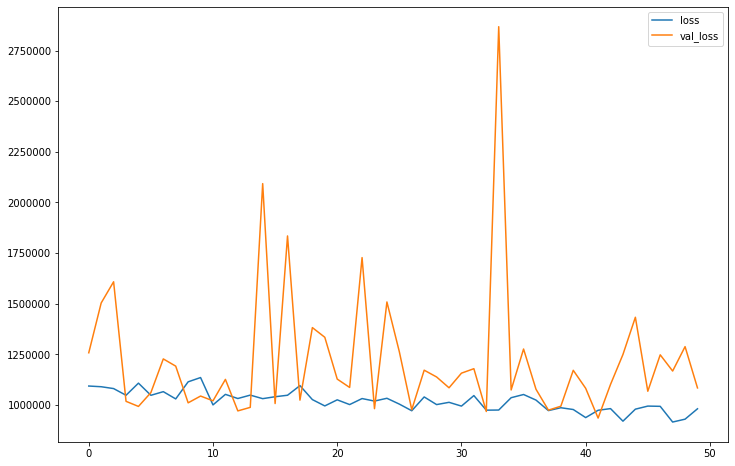

In [177]:
loss_df = pd.DataFrame(history_1.history)
loss_df.plot(figsize=(12,8))

In [236]:
%%time
y_pred_train = model_1.predict(X_train)
print('Train MAPE:', metrics.mean_absolute_percentage_error(y_train, y_pred_train)*100)

Train MAPE: 21.304185457436382
CPU times: user 2min 7s, sys: 5.01 s, total: 2min 12s
Wall time: 1min 7s


In [237]:
%%time
y_pred_val = model_1.predict(X_val)
print('Val MAPE:', metrics.mean_absolute_percentage_error(y_val, y_pred_val)*100)

Val MAPE: 18.910280887208643
CPU times: user 31.7 s, sys: 1.26 s, total: 33 s
Wall time: 15.8 s


In [105]:
print('MAE:', metrics.mean_absolute_error(y_val, y_pred_val))  
print('MSE:', metrics.mean_squared_error(y_val, y_pred_val))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_val, y_pred_val)))
print('VarScore:',metrics.explained_variance_score(y_val, y_pred_val))

MAE: 3077.1738352995058
MSE: 26439119.576893177
RMSE: 5141.89844093533
VarScore: 0.9993895804993767


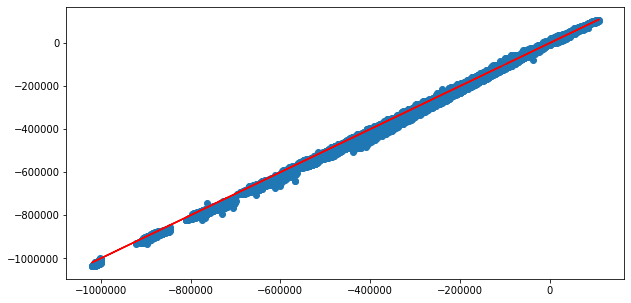

In [44]:
# Visualizing Our predictions
fig = plt.figure(figsize=(10,5))
plt.scatter(y_val,y_pred_val)
# Perfect predictions
plt.plot(y_val,y_val,'r')